In [ ]:
import pandas as pd
import numpy as np   
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [36]:

df = pd.read_csv('../../data/preprocessed_flight_data.csv')


print(df.shape)
df.head()


(6965266, 37)


,Unnamed: 0,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,...,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_dep_delayed,is_arr_delayed
0,0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",...,122.0,84.0,509.0,0,0,0,0,0,False,False
1,1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",...,114.0,88.0,622.0,0,0,0,0,0,False,False
2,2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",...,90.0,61.0,288.0,0,0,0,0,0,False,False
3,3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",...,76.0,51.0,288.0,0,0,0,0,0,False,False
4,4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",...,70.0,45.0,237.0,0,0,0,0,0,False,False


In [37]:
df_delayed = df[df['is_arr_delayed'] == 1].copy()

print("Original dataset shape:", df.shape)
print("Filtered dataset shape (only delayed flights):", df_delayed.shape)


Original dataset shape: (6965266, 37)
Filtered dataset shape (only delayed flights): (2522008, 37)


In [38]:
features = [
    'op_unique_carrier',  # carrier
    'origin',             # departure airport
    'dest',               # arrival airport
    'dep_time',           # departure time
    'distance',           # flight distance
    'taxi_out',           # taxi-out time
    'taxi_in',            # taxi-in time
    'crs_arr_time'        # scheduled arrival time
]


In [39]:
X = df_delayed[features].copy()
X.head()


,op_unique_carrier,origin,dest,dep_time,distance,taxi_out,taxi_in,crs_arr_time
13,9E,GRR,DTW,12:50:00,120.0,27.0,11.0,13:57:00
21,9E,MIA,RDU,17:58:00,700.0,34.0,7.0,20:02:00
22,9E,RDU,MIA,14:41:00,700.0,19.0,16.0,16:59:00
39,9E,DHN,ATL,06:42:00,170.0,16.0,33.0,08:54:00
54,9E,CLT,JFK,19:37:00,541.0,26.0,5.0,18:45:00


In [40]:
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

X.head()


,op_unique_carrier,origin,dest,dep_time,distance,taxi_out,taxi_in,crs_arr_time
13,0,136,98,630,120.0,27.0,11.0,684
21,0,216,272,938,700.0,34.0,7.0,1049
22,0,272,216,741,700.0,19.0,16.0,866
39,0,92,20,262,170.0,16.0,33.0,381
54,0,69,173,1037,541.0,26.0,5.0,972


In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [42]:

from sklearn.decomposition import PCA


# PCA reduction
pca = PCA(n_components=4, random_state=42)
X_reduced = pca.fit_transform(X_scaled)

# Birch clustering
birch_model = Birch(n_clusters=10, threshold=0.7, branching_factor=50)
birch_model.fit(X_reduced)

# Evaluate on a sample
sample_idx = np.random.choice(len(X_reduced), size=int(0.1 * len(X_reduced)), replace=False)
X_sample = X_reduced[sample_idx]
labels_sample = birch_model.labels_[sample_idx]

silhouette = silhouette_score(X_sample, labels_sample)
ch_index = calinski_harabasz_score(X_sample, labels_sample)
db_index = davies_bouldin_score(X_sample, labels_sample)

print("==== Clustering Evaluation ====")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Index: {ch_index:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print("Number of clusters found:", len(np.unique(birch_model.labels_)))


==== Clustering Evaluation ====
Silhouette Score: 0.1108
Calinski-Harabasz Index: 17678.6024
Davies-Bouldin Index: 1.4483
Number of clusters found: 10


In [43]:
df_delayed['cluster'] = birch_model.labels_


In [44]:
cluster_summary = df_delayed.groupby('cluster').agg({
    'distance': ['mean', 'median'],
    'dep_delay': ['mean', 'median'],
    'taxi_out': 'mean',
    'taxi_in': 'mean'
})
print(cluster_summary)


            distance          dep_delay          taxi_out     taxi_in
                mean  median       mean median       mean        mean
cluster                                                              
0        1152.380651  1005.0  28.988598    1.0  18.983965   42.355081
1        1082.390906   930.0  40.156362    3.0  18.596513   86.244249
2         970.384940   888.0  43.012609   18.0  28.953991    7.168549
3         708.376902   623.0  46.885819   24.0  18.395428    8.891242
4         695.514256   602.0  30.930722   10.0  22.534462    8.082804
5        1852.744129  1874.0  43.462711   17.0  19.668216   12.381602
6         805.104383   740.0  31.776575    4.0  81.496483    6.669192
7         984.424242   868.0  51.121212   33.0  22.727273  250.090909
8         714.814352   641.0  21.599519   -1.0  15.619557   30.187547
9         841.419540   754.0  58.580460   15.0  19.624521  153.247126


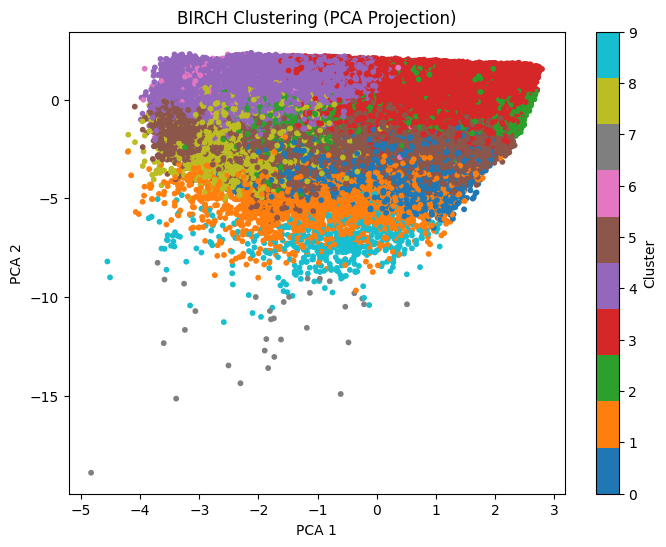

In [45]:


plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=birch_model.labels_, cmap='tab10', s=10)
plt.title('BIRCH Clustering (PCA Projection)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()
